In [ ]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
import scipy.io
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from hopls import matricize, qsquared, HOPLS
import random
from qpfs import *
random_seed = 5
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
#!CUBLAS_WORKSPACE_CONFIG=:16:8#:4096:8
device='cuda:0'

In [2]:
# Plotting train and test losses
def visualize(fig, train_loss, test_loss, clean=True):
    if clean:
        fig.clear()
    plt.plot(train_loss, color='red',label='train')
    plt.plot(test_loss, color='blue',label='test')
    plt.grid(linestyle='--')
    plt.yscale('log')
    plt.legend()
    if clean:
        clear_output(wait=True)
        display(fig);
    else:
        plt.show()

In [3]:
def metric_nmse_(Y_pred, Y):
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))

def rmse_LR(autoencoder, X_train, X_test, Y_train, Y_test):
    X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(X_train.size(0),-1)
    X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(X_test.size(0),-1)
    lregr = LinearRegression()
    lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
    rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr)
    return rmse

def rmse_TR(autoencoder, X_train, X_test, Y_train, Y_test):
    X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
    X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
    est = TuckerRegressor(weight_ranks=X_train_lower.shape[1:], verbose=0);
    Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
    for i in range(3):
        est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
        Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
    rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
    return rmse

### Functions for PLS, CCA, HOPLS

In [4]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar

def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [17]:
# Function for PLS and CCA training
def CCA_PLS_test(Y_train, Y_test, X_train, X_test, k_max, algorithm = 'CCA', plot=True):
    step = 3
    n_restarts = 5

    Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
    Xtrain_ar, Xtest_ar = X_train[:X_train.shape[0] - step + 1], X_test[:X_test.shape[0] - step + 1]

    rmse = []
    for k in range(1, k_max):#tqdm(range(1, k_max)):
        if algorithm == 'CCA':
            pls = CCA(n_components=k)
        else:
            pls = PLSRegression(n_components=k)
        tr = []
        te = []
        for i in range(n_restarts):
            X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
            pls.fit(X, Y)
            tr.append(metric_nmse(X, Y, pls))
            te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
        rmse.append((k, tr, te))

    x = [r[0] for r in rmse]
    y1_mean = np.array([np.mean(r[1]) for r in rmse])
    y2_mean = np.array([np.mean(r[2]) for r in rmse])
    y1_std = np.array([np.std(r[1]) for r in rmse])
    y2_std = np.array([np.std(r[2]) for r in rmse])
    if plot:
        plt.figure(figsize=(6, 5))

        plt.plot(x, y1_mean, label='train')
        plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

        plt.plot(x, y2_mean, label='test')
        plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
        plt.ylabel(r'sRMSE')
        plt.xlabel(algorithm + r'latent space dimensionality, $l$')

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))
    return min(y2_mean)

def compute_rmse_hopls(tdata, tlabel, vdata, vlabel, Ln, Km, R_max=30):
    model = HOPLS(R_max, Ln, Km, epsilon=1e-3)
    model.fit(tdata, tlabel)
    prediction, R, prediction_scores = model.predict(vdata, vlabel)
    rmse_test = metric_nmse_(prediction.detach().numpy(), vlabel.detach().numpy())
    prediction, R, prediction_scores = model.predict(tdata, tlabel)
    rmse_train = metric_nmse_(prediction.detach().numpy(), tlabel.detach().numpy())
    return rmse_test, rmse_train, R

### Loss functions

##### Base loss function:
$$ \mathcal{L} = \mathcal{L}_{rec} + l \cdot \mathcal{L}_{dec},$$
where:
$$ \mathcal{L}_{rec} = \frac{1}{n} \sum_{i=1}^{n} \left( X_i - \psi \circ \phi (X_i) \right)^2 $$
$$ \mathcal{L}_{dec} = \frac{1}{m} \sum_{i=1}^{m} \left( Y_i - \omega \circ \phi (X_i) \right)^2 $$
where $n,m$ - number of elements of $X,~Y,$ respectively.

In [6]:
def compute_pearson(input):
    """
    input: tensor [b,c,n] or [b,c,h,w]
    return: pearson correlation coefficient [c,c]
    """
    batch, channel,_ = input.shape
    input = input.view(batch, channel,-1)
    mean = torch.mean(input,dim=0).unsqueeze(0)
    cov = torch.matmul(input-mean,(input-mean).permute(0,2,1))
    diag = torch.sum(torch.eye(channel).unsqueeze(0).to(device) * cov,dim=2).view(batch,channel,-1)
    stddev = torch.sqrt(torch.matmul(diag,diag.permute(0,2,1)))
    pearson = torch.div(cov,stddev)
    return pearson

In [7]:
def my_loss(l):
    def loss_(X, y, out, y_pred):
        return ((X-out)**2).mean() + l * ((y-y_pred)**2).mean()
    return loss_

def my_loss_Q(l,m):
    def loss_(X, y, out, y_pred, code):
        return ((X-out)**2).mean() + l * ((y-y_pred)**2).mean() + m * torch.mean(compute_pearson(code.reshape(X.size(0),-1,1)))
    return loss_

## Data

This data was collected from two phones, one of them was in a pocket, the other was in hand. A person made around 20 steps in a circle. Both phones collected data from accelerometers and one of them (in the hand) also collected data from gyroscope. We concatenated data from both accelerometers into $X$ and data from gyroscope considered as $Y$. For $X$ data we made a convertion into a frequency-time representation using a wavelet transform. So, $X \in \mathbb{R}^{T \times 6 \times 15}$, where $15$ - number of frequencies. $Y \in \mathbb{R}^{T \times 3}$ 

In [8]:
X = np.load('My_X.npy')
Y = np.load('My_Y.npy')
print('Shape X:',X.shape)
print('Shape Y:',Y.shape)

Shape X: (322, 6, 15)
Shape Y: (322, 3)


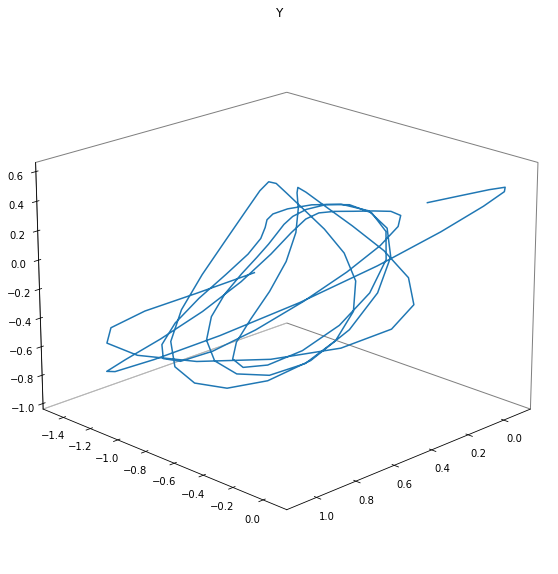

In [9]:
for i,data in [('Y',Y)]:
    with PdfPages(i+'.pdf') as pdf:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(data[30:150,0],
                data[30:150,1],
                data[30:150,2],
                label='parametric curve')
        ax.grid(False)
        ax.set_title(i)
        ax.xaxis.set_rotate_label(False)
        ax.yaxis.set_rotate_label(False)
        ax.zaxis.set_rotate_label(False)
        ax.view_init(elev=20, azim=45)
        ax.xaxis.pane.set_edgecolor('black')
        ax.yaxis.pane.set_edgecolor('black')
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        pdf.savefig()

Text(0.5, 1.0, 'X')

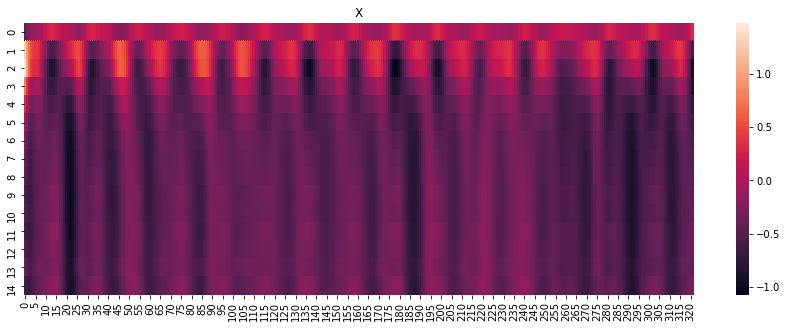

In [10]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(X[:,1,:].T)
ax.set_title('X')

In [11]:
# to torch
X_test = torch.from_numpy(X[250:]).to(torch.float32).permute(0,2,1).to(device)
Y_test = torch.from_numpy(Y[250:]).to(torch.float32).to(device)
X_train = torch.from_numpy(X[:250]).to(torch.float32).permute(0,2,1).to(device)
Y_train = torch.from_numpy(Y[:250]).to(torch.float32).to(device)

X_test = (X_test - X_test.mean()) / X_test.std() 
Y_test = (Y_test - Y_test.mean()) / Y_test.std()
X_train = (X_train - X_train.mean()) / X_train.std()
Y_train = (Y_train - Y_train.mean()) / Y_train.std()

IMAGE_WIDTH = X_train.shape[1]
IMAGE_HEIGHT = X_train.shape[2]
IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT

## PLS and CCA results

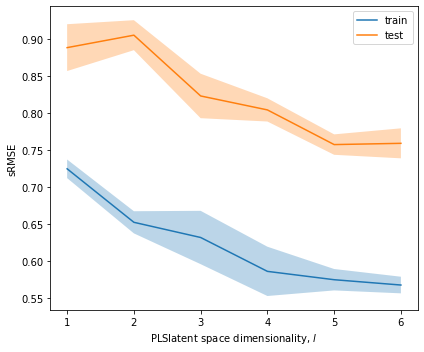

5 components with nRMSE = 0.7573423504833278


0.7573423504833278

In [28]:
CCA_PLS_test(Y_train.cpu(), Y_test.cpu(), X_train.cpu().reshape(-1,6*15), X_test.cpu().reshape(-1,6*15), 7, algorithm = 'PLS')

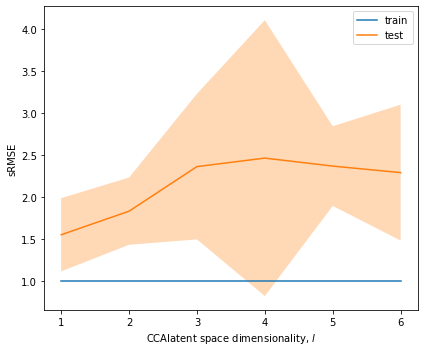

1 components with nRMSE = 1.5474069639380823


1.5474069639380823

In [29]:
CCA_PLS_test(Y_train.cpu(), Y_test.cpu(), X_train.cpu().reshape(-1,6*15), X_test.cpu().reshape(-1,6*15), 7)

In [18]:
MSE_test = {}
MSE_train = {}
for ks1 in tqdm(range(1,16)):
    for ks2 in range(1,7):
        for ks3 in range(1,4):
            Ln = [ks1,ks2]
            Km = [ks3]
            rmse_test, rmse_train, R = compute_rmse_hopls(X_train.cpu().double(), Y_train.cpu().double(), X_test.cpu().double(), Y_test.cpu().double(), Ln, Km, R_max=20)
            MSE_test[f'Ln = ({ks1},{ks2}), Km = {ks3}'] = rmse_test
            MSE_train[f'Ln = ({ks1},{ks2}), Km = {ks3}'] = rmse_train

print('Train. Size of core tensor is', min(MSE_train, key=MSE_train.get), 'nRMSE =', MSE_train[min(MSE_train, key=MSE_train.get)])
print('Test. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.36s/it]

Train. Size of core tensor is Ln = (3,1), Km = 1 nRMSE = 0.7758180922847216
Test. Size of core tensor is Ln = (3,1), Km = 1 nRMSE = 0.810812891784459


## Autoencoder with matrix output

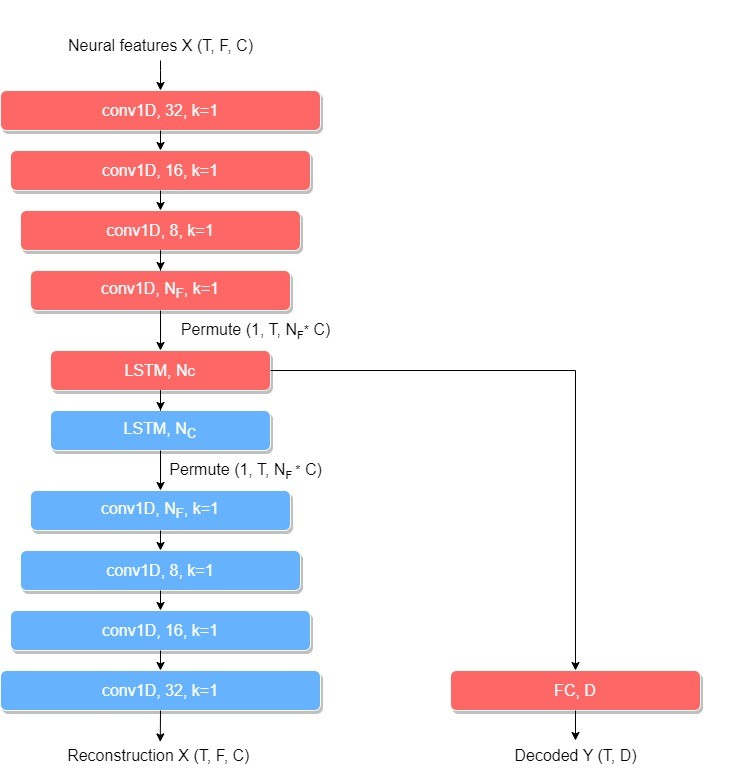

#### Model

In [49]:
class AutoEncoder(nn.Module):
    
    def __init__(self, N_ch, N_f):
        super().__init__()
        self.N_ch = N_ch
        self.N_f = N_f
        # Encoder specification
        self.enc_cnn_1 = nn.Sequential(
            nn.Conv1d(IMAGE_WIDTH, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        self.enc_cnn_2 = nn.Sequential(
            nn.Conv1d(32, 16, 1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        if N_ch >= 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        elif N_ch < 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.enc_cnn_4 = nn.Sequential(
                nn.Conv1d(8, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.enc_lstm = nn.LSTM(N_f*IMAGE_HEIGHT, N_ch, 1)
        
        # Decoder specification
        self.dec_lstm = nn.LSTM(N_ch, N_f*IMAGE_HEIGHT, 1)
        if N_ch < 8:
            self.dec_cnn_1 = nn.Sequential(
                nn.Conv1d(N_f, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(8, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05)) 
        else:
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(N_f, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.dec_cnn_3 = nn.Sequential(
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.dec_cnn_4 = nn.Sequential(
            nn.Conv1d(32, IMAGE_WIDTH, 1),
            nn.BatchNorm1d(IMAGE_WIDTH),
            nn.GELU(),
            nn.Dropout(p=0.05))
        
        self.fc = nn.Linear(N_ch, 3)
        
    def forward(self, images):
        code = self.encode(images)
        y_pred = self.fc(code)
        out = self.decode(code)
        return out, y_pred, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = self.enc_cnn_2(code)
        if self.N_ch < 8:
            code = self.enc_cnn_3(code)
            code = self.enc_cnn_4(code)
        else:
            code = self.enc_cnn_3(code)
        code = code.reshape([1,code.size(0),code.size(2)*code.size(1)])
        code,_ = self.enc_lstm(code)
        return code
    
    def decode(self, code):
        out,_ = self.dec_lstm(code)
        out = out.reshape([out.size(1),self.N_f,out.size(2)//self.N_f])
        if self.N_ch < 8:
            out = self.dec_cnn_1(out)
            out = self.dec_cnn_2(out)
        else:
            out = self.dec_cnn_2(out)
        out = self.dec_cnn_3(out)
        out = self.dec_cnn_4(out)
        return out

#### Finding the best parameters

In [50]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
for n,N_ch in enumerate(range(1,7)):
    for k,N_f in enumerate(range(1,16,1)):
        MSE.append([])
        for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
        # Instantiate model
            autoencoder = AutoEncoder(N_ch,N_f).to(device)
            loss_fn = my_loss(3)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_train_loss = []
            epoch_test_loss = []
            
            for epoch in range(200):
                #print("Epoch %d" % epoch)
                epoch_loss = []
                out, y_pred, code = autoencoder(X_train[train_index].double())
                optimizer.zero_grad()
                loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double())
                loss.backward()
                optimizer.step()
                scheduler.step()
                epoch_train_loss.append(loss.item())
                
                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double())
                    epoch_test_loss.append(loss.item())
                    
            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N_ch)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N_ch)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
            MSE[n*15+k].append(rmse)

3it [00:22,  7.42s/it]
3it [00:21,  7.33s/it]
3it [00:22,  7.34s/it]
3it [00:22,  7.52s/it]
3it [00:21,  7.04s/it]
3it [00:21,  7.25s/it]
3it [00:22,  7.34s/it]
3it [00:22,  7.34s/it]
3it [00:21,  7.26s/it]
3it [00:21,  7.23s/it]
3it [00:21,  7.04s/it]
3it [00:20,  6.98s/it]
3it [00:21,  7.10s/it]
3it [00:21,  7.19s/it]
3it [00:22,  7.34s/it]
3it [00:22,  7.51s/it]
3it [00:21,  7.19s/it]
3it [00:21,  7.23s/it]
3it [00:21,  7.19s/it]
3it [00:22,  7.38s/it]
3it [00:22,  7.37s/it]
3it [00:21,  7.21s/it]
3it [00:21,  7.32s/it]
3it [00:22,  7.41s/it]
3it [00:22,  7.38s/it]
3it [00:21,  7.30s/it]
3it [00:22,  7.35s/it]
3it [00:22,  7.35s/it]
3it [00:22,  7.38s/it]
3it [00:22,  7.51s/it]
3it [00:22,  7.39s/it]
3it [00:21,  7.33s/it]
3it [00:21,  7.24s/it]
3it [00:21,  7.12s/it]
3it [00:22,  7.34s/it]
3it [00:21,  7.16s/it]
3it [00:21,  7.23s/it]
3it [00:22,  7.37s/it]
3it [00:21,  7.27s/it]
3it [00:21,  7.29s/it]
3it [00:22,  7.50s/it]
3it [00:22,  7.55s/it]
3it [00:22,  7.35s/it]
3it [00:21,

In [51]:
rmse = 2
N, K = 0, 0
for n,N_ch in enumerate(range(1,7)):
    for k,N_f in enumerate(range(1,16,1)):
        if rmse > np.array(MSE[n*15+k]).mean():
            N = N_ch
            K = N_f
            rmse = np.array(MSE[n*15+k]).mean()
print(N, K, rmse)

6 11 0.641753537393838


$N_f = 11, N_{ch} = 6$ - the best parameters of MatrixAutoencoder

#### Training with best parameters

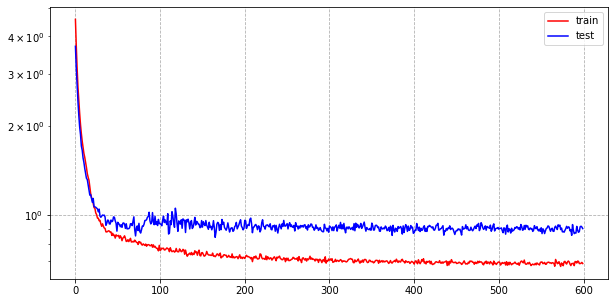

24163
nRMSE = 0.7201808629106523


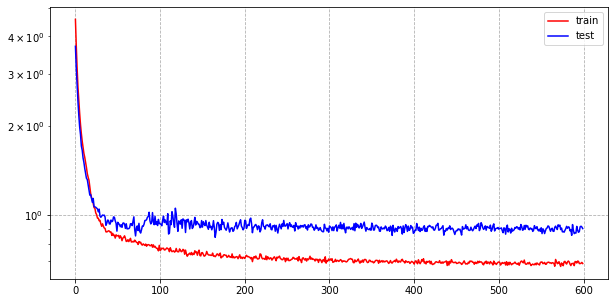

In [52]:
N, K = 6, 11
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam

autoencoder = AutoEncoder(N, K).to(device)
loss_fn = my_loss(3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(600):
    out, y_pred, code = autoencoder(X_train.double())
    optimizer.zero_grad()
    loss = loss_fn(X_train.double(), Y_train.double(), out.double(), y_pred.double())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_train.append(loss.item())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(-1,N)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(-1,N)
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:',sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

## Autoencoder with tensor output

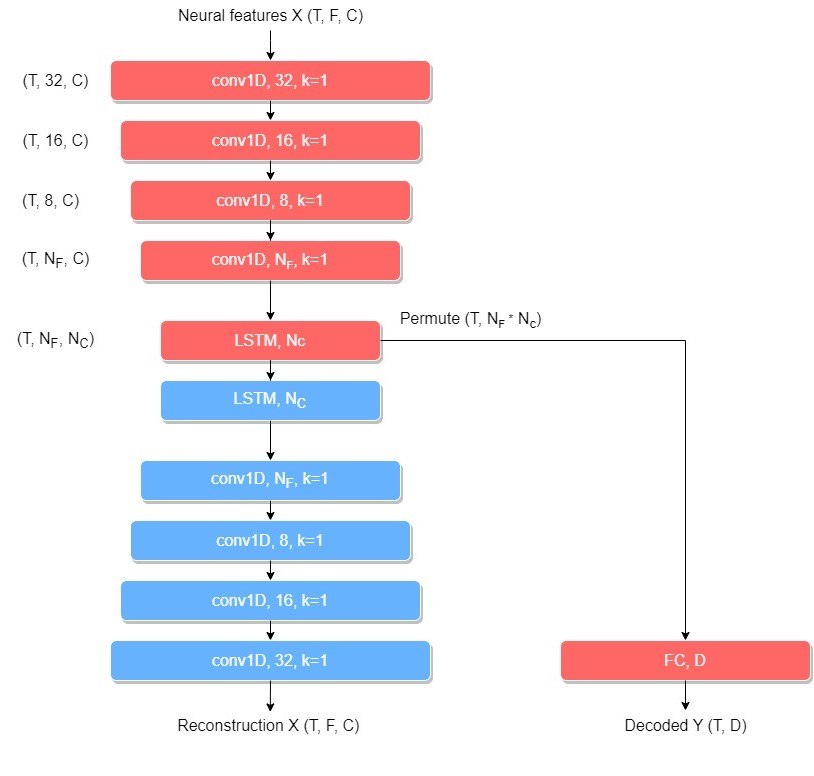

#### Model 

In [12]:
class AutoEncoder_(nn.Module):
    
    def __init__(self, N_ch, N_f):
        super().__init__()
        self.N_ch = N_ch
        self.N_f = N_f
        # Encoder specification
        self.enc_cnn_1 = nn.Sequential(
            nn.Conv1d(IMAGE_WIDTH, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.enc_cnn_2 = nn.Sequential(
            nn.Conv1d(32, 16, 1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        if N_ch >= 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        elif N_ch < 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.enc_cnn_4 = nn.Sequential(
                nn.Conv1d(8, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.enc_lstm = nn.LSTM(IMAGE_HEIGHT, N_ch, 1,batch_first=True)
        
        # Decoder specification
        self.dec_lstm = nn.LSTM(N_ch, IMAGE_HEIGHT, 1,batch_first=True)
            
        if N_ch < 8:
            self.dec_cnn_1 = nn.Sequential(
                nn.Conv1d(N_f, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(8, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05)) 
        else:
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(N_f, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.dec_cnn_3 = nn.Sequential(
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.dec_cnn_4 = nn.Sequential(
            nn.Conv1d(32, IMAGE_WIDTH, 1),
            nn.BatchNorm1d(IMAGE_WIDTH),
            nn.GELU(),
            nn.Dropout(p=0.05))
        
        self.fc = nn.Linear(N_ch*N_f, 3)
        
    def forward(self, images):
        code = self.encode(images)
        y_pred = self.fc(code.reshape([1,code.size(0),self.N_f*self.N_ch]))
        out = self.decode(code)
        return out, y_pred, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = self.enc_cnn_2(code)
        if self.N_ch < 8:
            code = self.enc_cnn_3(code)
            code = self.enc_cnn_4(code)
        else:
            code = self.enc_cnn_3(code)
        #code = code.reshape([1,code.size(0),code.size(2)*2])
        code,_ = self.enc_lstm(code)
        return code
    
    def decode(self, code):
        out,_ = self.dec_lstm(code)
        #out = out.reshape([out.size(1),2,out.size(2)//2])
        if self.N_ch < 8:
            out = self.dec_cnn_1(out)
            out = self.dec_cnn_2(out)
        else:
            out = self.dec_cnn_2(out)
        out = self.dec_cnn_3(out)
        out = self.dec_cnn_4(out)
        return out

#### Finding the best parameters

In [54]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N_ch, N_f
for n,N_ch in enumerate(range(1,7)):
    for k,N_f in enumerate(range(1,16,1)):
        MSE.append([])
        for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
            autoencoder = AutoEncoder_(N_ch,N_f).to(device)
            loss_fn = my_loss(3)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_train_loss = []
            epoch_test_loss = []
            
            for epoch in range(200):
                epoch_loss = []
                out, y_pred, code = autoencoder(X_train[train_index].double())
                optimizer.zero_grad()
                loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double())
                loss.backward()
                optimizer.step()
                scheduler.step()
                epoch_train_loss.append(loss.item())
                
                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double())
                    epoch_test_loss.append(loss.item())
                    
            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
            MSE[n*15+k].append(rmse)

3it [00:16,  5.50s/it]
3it [00:17,  5.99s/it]
3it [00:16,  5.62s/it]
3it [00:15,  5.31s/it]
3it [00:15,  5.26s/it]
3it [00:22,  7.66s/it]
3it [00:22,  7.33s/it]
3it [00:21,  7.25s/it]
3it [00:22,  7.46s/it]
3it [00:23,  7.76s/it]
3it [00:23,  7.70s/it]
3it [00:23,  7.70s/it]
3it [00:23,  7.83s/it]
3it [00:23,  8.00s/it]
3it [00:24,  8.01s/it]
3it [00:20,  6.97s/it]
3it [00:21,  7.22s/it]
3it [00:21,  7.32s/it]
3it [00:22,  7.50s/it]
3it [00:22,  7.56s/it]
3it [00:22,  7.66s/it]
3it [00:23,  7.69s/it]
3it [00:22,  7.64s/it]
3it [00:23,  7.88s/it]
3it [00:23,  7.69s/it]
3it [00:23,  7.74s/it]
3it [00:23,  7.88s/it]
3it [00:24,  8.25s/it]
3it [00:24,  8.30s/it]
3it [00:25,  8.49s/it]
3it [00:21,  7.08s/it]
3it [00:21,  7.05s/it]
3it [00:21,  7.31s/it]
3it [00:22,  7.56s/it]
3it [00:22,  7.62s/it]
3it [00:22,  7.35s/it]
3it [00:22,  7.41s/it]
3it [00:22,  7.49s/it]
3it [00:23,  7.68s/it]
3it [00:23,  7.82s/it]
3it [00:24,  8.07s/it]
3it [00:24,  8.21s/it]
3it [00:26,  8.69s/it]
3it [00:25,

In [55]:
rmse = 2
N, K = 0, 0
for n,N_ch in enumerate(range(1,7)):
    for k,N_f in enumerate(range(1,16,1)):
        if rmse > np.array(MSE[n*15+k]).mean():
            N = N_ch
            K = N_f
            rmse = np.array(MSE[n*15+k]).mean()
print(N, K, rmse)

2 5 0.6558684088044017


$N_f = 5, N_{ch} = 2$ - the best parameters of TensorAutoencoder

#### Training with best parameters

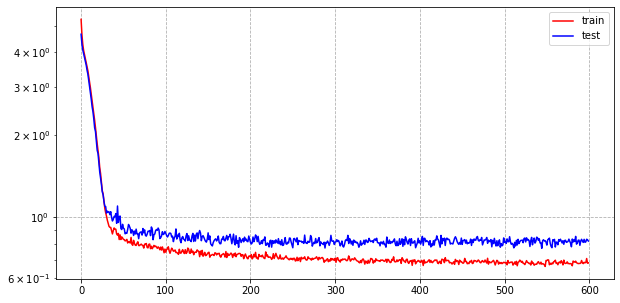

3069
nRMSE = 0.6822086118456689


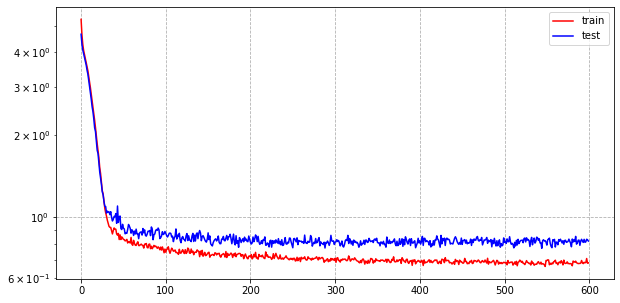

In [56]:
N, K = 2, 5

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_(N, K).to(device)
loss_fn = my_loss(3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(600):
    out, y_pred, code = autoencoder(X_train.double())
    optimizer.zero_grad()
    loss = loss_fn(X_train.double(), Y_train.double(), out.double(), y_pred.double())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_train.append(loss.item())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(-1,N*K)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(-1,N*K)
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:',sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

### Tensor regressions
#### CP regression

In [61]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
for rank in range(1,max(N,K)):
    est = CPRegressor(weight_rank=rank, verbose=0)
    Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
    for i in range(3):
        est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu());
        Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
    rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
    print(rank,'nRMSE by CPR regression = ', rmse)

1 nRMSE by CPR regression =  0.7233190860034003
2 nRMSE by CPR regression =  0.675928017094168
3 nRMSE by CPR regression =  0.6765807457036753
4 nRMSE by CPR regression =  0.6762974957961599


#### Tucker regression

In [62]:
for rank1 in range(1,K+1,1):   
    for rank2 in range(1,N+1,1):
        est = TuckerRegressor(weight_ranks=[rank1,rank2], verbose=0);
        Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
        for i in range(3):
            est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
            Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
        rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
        print(rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 nRMSE by Tucker regression =  0.7226409089934135
1 2 nRMSE by Tucker regression =  0.7224699915048948
2 1 nRMSE by Tucker regression =  0.7246935584988594
2 2 nRMSE by Tucker regression =  0.7190877460155543
3 1 nRMSE by Tucker regression =  0.7247482314649911
3 2 nRMSE by Tucker regression =  0.6757463668259228
4 1 nRMSE by Tucker regression =  0.7642849163221315
4 2 nRMSE by Tucker regression =  0.6753097054977877
5 1 nRMSE by Tucker regression =  0.765090317320882
5 2 nRMSE by Tucker regression =  0.6759205293946939


#### HOPLS

In [64]:
for l in range(1,max(K,N)+1):
    _,_,rmse,_ = compute_rmse_hopls(torch.tensor(X_train_lower).double(), Y_train.cpu().double(),
                              torch.tensor(X_test_lower).double(), Y_test.cpu().double(), l)
    print(l,rmse)

1 0.6662446291867008
2 0.6773184685299939
3 0.6710408729143382
4 0.692478419431564
5 0.6872894600094502


### With addition correlation in loss function


$$ \mathcal{L} = \mathcal{L}_{rec} + l \cdot \mathcal{L}_{dec} + m \cdot \mathcal{L}_{cor}, $$
where:
$$ \mathcal{L}_{rec} = \frac{1}{n} \sum_{i=1}^{n} \left( X_i - \psi \circ \phi (X_i) \right)^2 $$
$$ \mathcal{L}_{dec} = \frac{1}{m} \sum_{i=1}^{m} \left( Y_i - \omega \circ \phi (X_i) \right)^2 $$
$$ \mathcal{L}_{cor} = \frac{1}{k^2} \sum_{i=1}^{k} \sum_{j=1}^{k} corr(\psi(X)_i,~\psi(X)_j) $$
where $n,m,k$ - number of elements of $X$, $Y$ and $\psi(X)$, respectively.

##### Finding the best parameters for loss and learning rate

In [38]:
#N_f, N_ch = 12, 6

N, K = 2, 5 # parameters as in previous step

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

MSE = {}
optimizer_cls = optim.Adam
lr = 0.005
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)

for m in [0,0.01,0.1,1,3,5,10]:
    for l in [0.1,1,3,5,10]:
        MSE['m='+str(m)+', l='+str(l)+', lr='+str(lr)] = []
        for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
            autoencoder = AutoEncoder_(N, K).to(device)
            loss_fn = my_loss_Q(l,m)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_test_loss = []
            loss_train = []

            for epoch in range(400):
                out, y_pred, code = autoencoder(X_train[train_index].double())
                optimizer.zero_grad()
                loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double(), code.double())
                loss.backward()
                optimizer.step()
                scheduler.step()
                loss_train.append(loss.item())

                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double(), code.double())
                    epoch_test_loss.append(loss.item())

            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N*K)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N*K)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr);
            MSE['m='+str(m)+', l='+str(l)+', lr='+str(lr)].append(rmse)

3it [00:33, 11.08s/it]
3it [00:34, 11.43s/it]
3it [00:33, 11.09s/it]
3it [00:33, 11.11s/it]
3it [00:32, 10.75s/it]
3it [00:36, 12.02s/it]
3it [00:35, 11.91s/it]
3it [00:36, 12.05s/it]
3it [00:35, 11.91s/it]
3it [00:35, 11.91s/it]
3it [00:35, 11.98s/it]
3it [00:36, 12.10s/it]
3it [00:35, 11.89s/it]
3it [00:35, 11.90s/it]
3it [00:35, 11.93s/it]
3it [00:35, 11.72s/it]
3it [00:39, 13.05s/it]
3it [00:42, 14.21s/it]
3it [00:42, 14.27s/it]
3it [00:43, 14.51s/it]
3it [00:40, 13.61s/it]
3it [00:43, 14.56s/it]
3it [00:43, 14.41s/it]
3it [00:42, 14.15s/it]
3it [00:42, 14.28s/it]
3it [00:35, 11.96s/it]
3it [00:36, 12.30s/it]
3it [00:41, 13.93s/it]
3it [00:42, 14.31s/it]
3it [00:43, 14.52s/it]
3it [00:43, 14.37s/it]
3it [00:43, 14.58s/it]
3it [00:39, 13.29s/it]
3it [00:35, 12.00s/it]
3it [00:34, 11.55s/it]


In [39]:
for key in MSE:
    MSE[key] = np.array(MSE[key]).mean()
    
print('Best parameters are', min(MSE, key=MSE.get), 'nRMSE =', MSE[min(MSE, key=MSE.get)])

Best parameters are m=3, l=10, lr=0.005 nRMSE = 0.643161271096602


The best parameters: 
$$m=3,~l=10,~lr=0.005$$

##### Finding best parameters for autoencoder

In [40]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.005
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
for n,N_ch in enumerate(range(1,7)):
    for k,N_f in enumerate(range(1,16,1)):
        MSE.append([])
        for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
        # Instantiate model
            autoencoder = AutoEncoder_(N_ch,N_f).to(device)
            loss_fn = my_loss_Q(10,3)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_train_loss = []
            epoch_test_loss = []
            
            for epoch in range(200):
                #print("Epoch %d" % epoch)
                epoch_loss = []
                out, y_pred, code = autoencoder(X_train[train_index].double())
                optimizer.zero_grad()
                loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double(), code.double())
                loss.backward()
                optimizer.step()
                scheduler.step()
                epoch_train_loss.append(loss.item())
                
                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double(), code.double())
                    epoch_test_loss.append(loss.item())
                    
            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
            MSE[n*15+k].append(rmse)

3it [00:20,  6.73s/it]
3it [00:21,  7.00s/it]
3it [00:21,  7.11s/it]
3it [00:21,  7.15s/it]
3it [00:21,  7.20s/it]
3it [00:20,  6.80s/it]
3it [00:21,  7.11s/it]
3it [00:22,  7.40s/it]
3it [00:22,  7.54s/it]
3it [00:22,  7.41s/it]
3it [00:22,  7.60s/it]
3it [00:22,  7.57s/it]
3it [00:23,  7.70s/it]
3it [00:22,  7.52s/it]
3it [00:23,  7.76s/it]
3it [00:18,  6.09s/it]
3it [00:17,  5.97s/it]
3it [00:17,  5.98s/it]
3it [00:18,  6.14s/it]
3it [00:18,  6.05s/it]
3it [00:18,  6.02s/it]
3it [00:16,  5.50s/it]
3it [00:18,  6.05s/it]
3it [00:18,  6.03s/it]
3it [00:16,  5.48s/it]
3it [00:16,  5.44s/it]
3it [00:16,  5.43s/it]
3it [00:18,  6.32s/it]
3it [00:19,  6.36s/it]
3it [00:18,  6.12s/it]
3it [00:15,  5.09s/it]
3it [00:15,  5.25s/it]
3it [00:17,  5.80s/it]
3it [00:17,  5.96s/it]
3it [00:17,  5.91s/it]
3it [00:18,  6.01s/it]
3it [00:18,  6.13s/it]
3it [00:19,  6.43s/it]
3it [00:22,  7.37s/it]
3it [00:22,  7.38s/it]
3it [00:22,  7.55s/it]
3it [00:23,  7.85s/it]
3it [00:24,  8.01s/it]
3it [00:23,

In [41]:
rmse = 2
N, K = 0, 0
for n,N_ch in enumerate(range(1,7)):
    for k,N_f in enumerate(range(1,16,1)):
        if rmse > np.array(MSE[n*15+k]).mean():
            N = N_ch
            K = N_f
            rmse = np.array(MSE[n*15+k]).mean()
print(N, K, rmse)

3 2 0.652353992710235


$N_f = 2, N_{ch} = 3$ - the best parameters of TensorAutoencoder with other loss

##### Training with best parameters

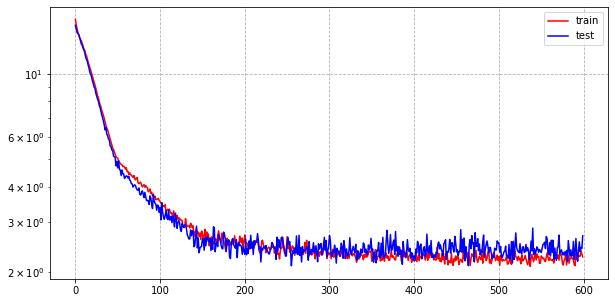

Number of parameters: 3076
nRMSE = 0.7051195970980658


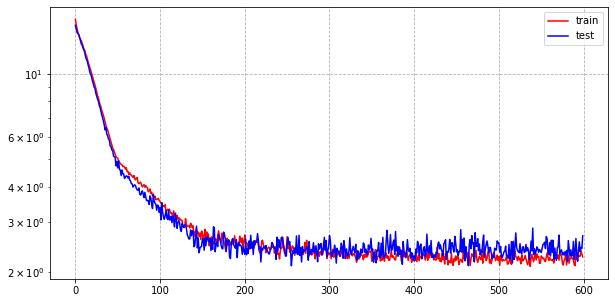

In [42]:
N, K = 3, 2

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.005
optimizer_cls = optim.Adam
autoencoder = AutoEncoder_(N, K).to(device)
loss_fn = my_loss_Q(10,3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(600):
    out, y_pred, code = autoencoder(X_train.double())
    optimizer.zero_grad()
    loss = loss_fn(X_train.double(), Y_train.double(), out.double(), y_pred.double(), code.double())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_train.append(loss.item())

    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double(), code.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 

X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(-1,N*K)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(-1,N*K)
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:',sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

#### Tensor regression

##### CP

In [43]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()

for rank in range(1,max(N,K)):
    est = CPRegressor(weight_rank=rank, verbose=0)
    Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
    for i in range(3):
        est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu());
        Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
    rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
    print(rank,'nRMSE by CPR regression = ', rmse)

1 nRMSE by CPR regression =  0.6528110602094142
2 nRMSE by CPR regression =  0.6538385341907226


##### Tucker

In [44]:
for rank1 in range(1,K+1,1):   
    for rank2 in range(1,N+1,1):
        est = TuckerRegressor(weight_ranks=[rank1,rank2], verbose=0);
        Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
        for i in range(3):
            est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
            Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
        rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
        print(rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 nRMSE by Tucker regression =  0.6531515843540077
1 2 nRMSE by Tucker regression =  0.6534548519786604
1 3 nRMSE by Tucker regression =  0.6544165553506863
2 1 nRMSE by Tucker regression =  0.6554200066187595
2 2 nRMSE by Tucker regression =  0.6553589509307772
2 3 nRMSE by Tucker regression =  0.6540550841824749


##### HOPLS

In [45]:
for l in range(1,max(K,N)+1):
    _,_,rmse,_ = compute_rmse_hopls(torch.tensor(X_train_lower).double(), Y_train.cpu().double(),
                              torch.tensor(X_test_lower).double(), Y_test.cpu().double(), l)
    print(l,rmse)

1 0.6567106390242736
2 0.6566244738818047
3 0.6912729063725056


### Autoencoder with different number of dimensions

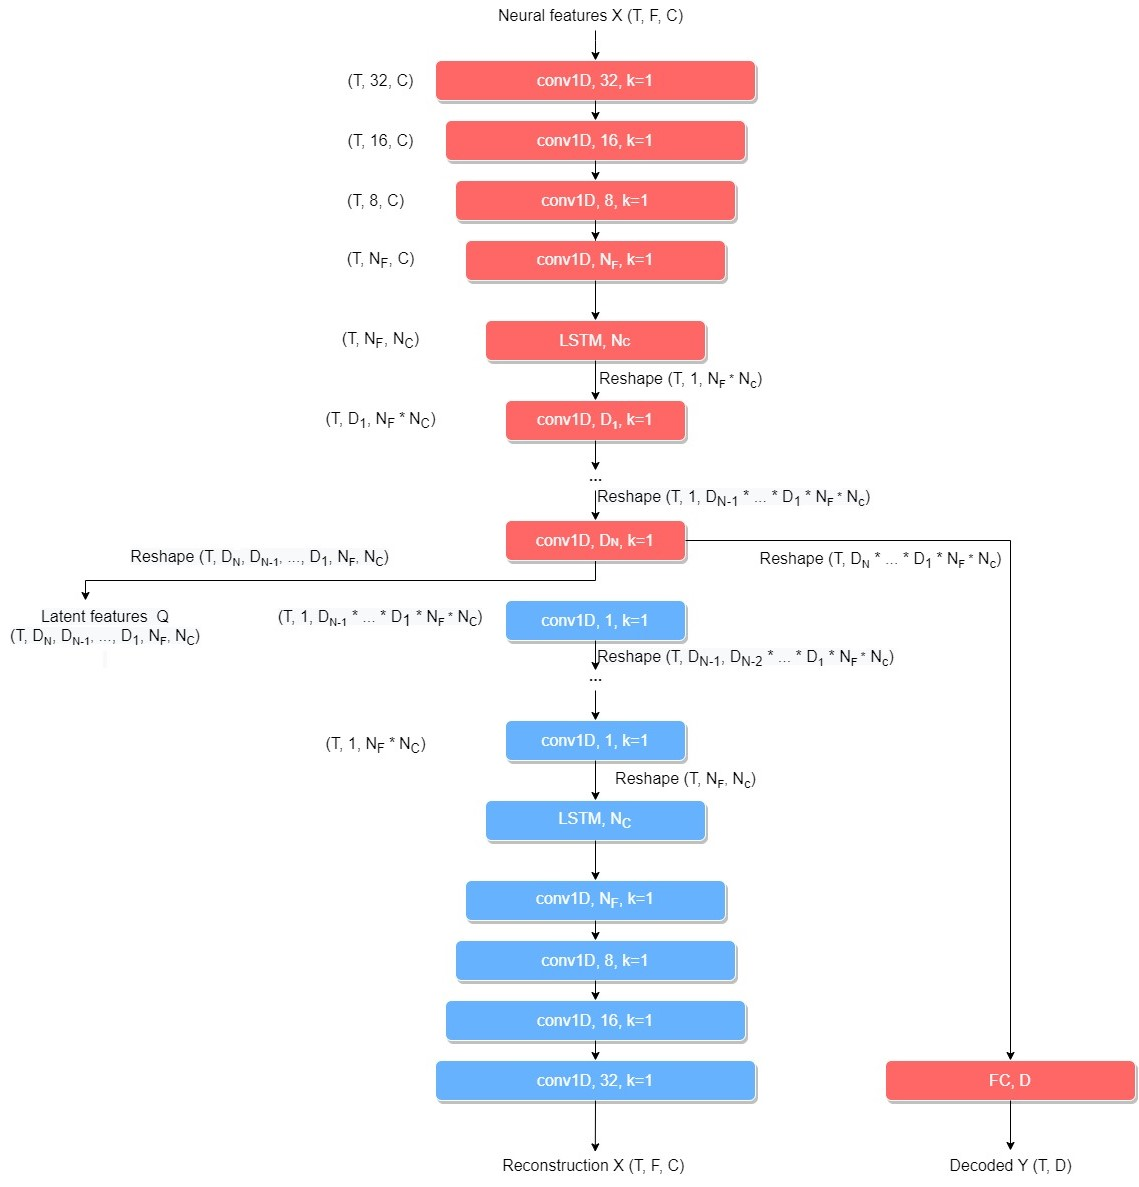

In [46]:
class AutoEncoder_d(nn.Module):
    def __init__(self, N_ch, N_f, f_dim=None):
        super().__init__()
        '''
        f_dim - list
        '''
        self.N_ch = N_ch
        self.N_f = N_f
        # Encoder specification
        self.enc_cnn_1 = nn.Sequential(
            nn.Conv1d(IMAGE_WIDTH, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.enc_cnn_2 = nn.Sequential(
            nn.Conv1d(32, 16, 1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        if N_f >= 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        elif N_f < 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.enc_cnn_4 = nn.Sequential(
                nn.Conv1d(8, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.enc_lstm = nn.LSTM(IMAGE_HEIGHT, N_ch, 1,batch_first=True)
        
        # Decoder specification
        self.dec_lstm = nn.LSTM(N_ch, IMAGE_HEIGHT, 1,batch_first=True)
            
        if N_f < 8:
            self.dec_cnn_1 = nn.Sequential(
                nn.Conv1d(N_f, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(8, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05)) 
        else:
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(N_f, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.dec_cnn_3 = nn.Sequential(
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.dec_cnn_4 = nn.Sequential(
            nn.Conv1d(32, IMAGE_WIDTH, 1),
            nn.BatchNorm1d(IMAGE_WIDTH),
            nn.GELU(),
            nn.Dropout(p=0.05))
        
        self.fdim = f_dim
        if f_dim != None:
            self.fc = nn.Linear(np.prod(self.fdim)*N_ch*N_f, 3)
            fc_list_up = []
            fc_list_down = []
            for f_d in f_dim:
                fc_list_up.append(nn.Sequential(nn.Conv1d(1, f_d, 1),nn.BatchNorm1d(f_d),nn.GELU(),nn.Dropout(p=0.05),
                                                nn.Conv1d(f_d, f_d, 1),nn.BatchNorm1d(f_d),nn.GELU(),nn.Dropout(p=0.05)))
                fc_list_down.append(nn.Sequential(nn.Conv1d(f_d, f_d, 1),nn.BatchNorm1d(f_d),nn.GELU(),nn.Dropout(p=0.05),
                                                  nn.Conv1d(f_d, 1, 1),nn.BatchNorm1d(1),nn.GELU(),nn.Dropout(p=0.05)))
            self.fc_list_up =  nn.ModuleList(fc_list_up)   
            self.fc_list_down =  nn.ModuleList(fc_list_down[::-1]) 
        else:
            self.fc = nn.Linear(N_ch*N_f, 3)
        
        
    def forward(self, images):
        code = self.encode(images)
        y_pred = self.fc(code.reshape([code.size(0),-1]))
        out = self.decode(code)
        return out, y_pred, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = self.enc_cnn_2(code)
        if self.N_f < 8:
            code = self.enc_cnn_3(code)
            code = self.enc_cnn_4(code)
        else:
            code = self.enc_cnn_3(code)
        #code = code.reshape([1,code.size(0),code.size(2)*2])
        code,_ = self.enc_lstm(code)
        if self.fdim != None:
            for layer in self.fc_list_up:
                code = layer(code.reshape(code.size(0),1,-1))  
            code = code.reshape([code.size(0)]+self.fdim[::-1]+[self.N_f,self.N_ch])
        return code
    
    def decode(self, out):
        if self.fdim != None:
            for i,layer in enumerate(self.fc_list_down):
                out = layer(out.reshape(out.size(0),self.fdim[::-1][i],-1))
            out = out.reshape(out.size(0),self.N_f,self.N_ch)
        out,_ = self.dec_lstm(out)
        #out = out.reshape([out.size(1),2,out.size(2)//2])
        if self.N_f < 8:
            out = self.dec_cnn_1(out)
            out = self.dec_cnn_2(out)
        else:
            out = self.dec_cnn_2(out)
        out = self.dec_cnn_3(out)
        out = self.dec_cnn_4(out)
        return out

#### Finding best parameters

In [47]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device='cuda:0'
lr = 0.01
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
f_dims = [None,[2],[3],[4],[5],[6],[7],[8],[2,2],[2,3],[3,2],[3,3],[4,4]]
for f,f_dim in enumerate(f_dims):
    for n,N_ch in enumerate(range(1,4)):
        for k,N_f in enumerate(range(4,7)):
            MSE.append([])
            for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
            # Instantiate model
                autoencoder = AutoEncoder_d(N_ch,N_f,f_dim).to(device)
                loss_fn = my_loss(3)
                optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
                epoch_train_loss = []
                epoch_test_loss = []

                for epoch in range(200):
                    #print("Epoch %d" % epoch)
                    epoch_loss = []
                    out, y_pred, code = autoencoder(X_train[train_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_train_loss.append(loss.item())

                    with torch.no_grad():
                        out, y_pred, code = autoencoder(X_train[test_index].double())
                        optimizer.zero_grad()
                        loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double())
                        epoch_test_loss.append(loss.item())

                X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(len(train_index),-1)
                X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(len(test_index),-1)
                lregr = LinearRegression()
                lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
                rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
                MSE[f*3*3+n*3+k].append(rmse)

3it [00:21,  7.26s/it]
3it [00:21,  7.18s/it]
3it [00:21,  7.19s/it]
3it [00:21,  7.04s/it]
3it [00:21,  7.24s/it]
3it [00:21,  7.15s/it]
3it [00:21,  7.13s/it]
3it [00:22,  7.39s/it]
3it [00:22,  7.49s/it]
3it [00:28,  9.36s/it]
3it [00:28,  9.41s/it]
3it [00:28,  9.46s/it]
3it [00:28,  9.50s/it]
3it [00:28,  9.39s/it]
3it [00:28,  9.39s/it]
3it [00:27,  9.31s/it]
3it [00:28,  9.42s/it]
3it [00:26,  8.79s/it]
3it [00:27,  9.17s/it]
3it [00:27,  9.16s/it]
3it [00:26,  8.85s/it]
3it [00:26,  8.94s/it]
3it [00:26,  8.76s/it]
3it [00:25,  8.57s/it]
3it [00:25,  8.44s/it]
3it [00:26,  8.87s/it]
3it [00:27,  9.03s/it]
3it [00:26,  8.99s/it]
3it [00:26,  8.79s/it]
3it [00:26,  8.95s/it]
3it [00:27,  9.12s/it]
3it [00:26,  8.90s/it]
3it [00:27,  9.12s/it]
3it [00:26,  8.95s/it]
3it [00:26,  8.99s/it]
3it [00:27,  9.01s/it]
3it [00:27,  9.10s/it]
3it [00:27,  9.09s/it]
3it [00:26,  8.93s/it]
3it [00:26,  8.75s/it]
3it [00:26,  8.85s/it]
3it [00:28,  9.62s/it]
3it [00:28,  9.50s/it]
3it [00:28,

In [48]:
rmse = 2
N, K, F = 0, 0, 0
for f,f_dim in enumerate(f_dims):
    for n,N_ch in enumerate(range(1,4)):
        for k,N_f in enumerate(range(4,7)):
            if (f_dim!=None):
                if rmse > np.array(MSE[f*3*3+n*3+k]).mean():
                    N = N_ch
                    K = N_f
                    F = f_dim
                    rmse = np.array(MSE[f*3*3+n*3+k]).mean()
print(N, K, F, rmse)

2 6 [2] 0.7066775099177831


#### Training with best parameters

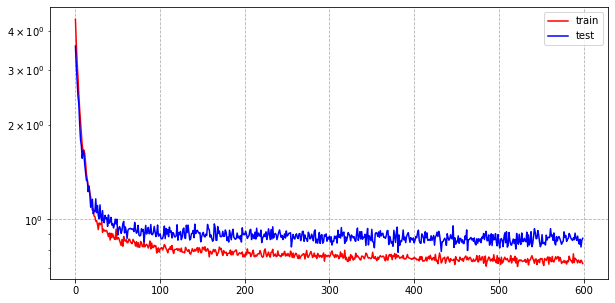

Number of parameters: 3163
nRMSE = 0.709558050164229


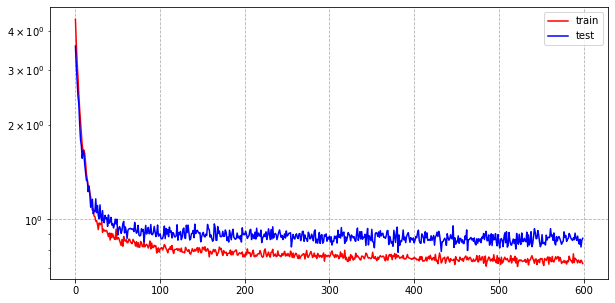

In [49]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

f_dim, N_f, N_ch = F, K, N

lr = 0.01
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_d(N_ch, N_f, f_dim).to(device)
loss_fn = my_loss(3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(600):
    out, y_pred, code = autoencoder(X_train.double())
    optimizer.zero_grad()
    loss = loss_fn(X_train.double(), Y_train.double(), out.double(), y_pred.double())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_train.append(loss.item())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(X_train.size(0),-1)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(X_test.size(0),-1)
                    
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:',sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

In [50]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
X_train_lower.shape

(250, 2, 6, 2)

In [51]:
for rank in range(1,3,1):
    for rank1 in range(1,7,1):   
        for rank2 in range(1,3,1):
            est = TuckerRegressor(weight_ranks=[rank,rank1,rank2], verbose=0);
            Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
            for i in range(3):
                est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
                Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
            rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
            print(rank, rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 1 nRMSE by Tucker regression =  0.7771989676153553
1 1 2 nRMSE by Tucker regression =  0.7477021631463664
1 2 1 nRMSE by Tucker regression =  0.85815883759591
1 2 2 nRMSE by Tucker regression =  0.7184513252810727
1 3 1 nRMSE by Tucker regression =  0.8280468765446822
1 3 2 nRMSE by Tucker regression =  0.8848059841754159
1 4 1 nRMSE by Tucker regression =  0.7751433136273268
1 4 2 nRMSE by Tucker regression =  0.8138473235237242
1 5 1 nRMSE by Tucker regression =  0.7186940424511309
1 5 2 nRMSE by Tucker regression =  0.7186545786689821
1 6 1 nRMSE by Tucker regression =  0.7192939456444933
1 6 2 nRMSE by Tucker regression =  0.7162048580270747
2 1 1 nRMSE by Tucker regression =  0.7489398681176812
2 1 2 nRMSE by Tucker regression =  0.7021443926307332
2 2 1 nRMSE by Tucker regression =  0.7090443614603164
2 2 2 nRMSE by Tucker regression =  0.7104667469757319
2 3 1 nRMSE by Tucker regression =  0.7166022511564245
2 3 2 nRMSE by Tucker regression =  0.6904790908779392
2 4 1 nRMSE 

### With addition correlation in loss function

In [52]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device='cuda:0'
lr = 0.005
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
f_dims = [None,[2],[3],[4],[5],[6],[7],[8],[2,2],[2,3],[3,2],[3,3],[4,4]]
for f,f_dim in enumerate(f_dims):
    for n,N_ch in enumerate(range(1,4)):
        for k,N_f in enumerate(range(4,7)):
            MSE.append([])
            for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
            # Instantiate model
                autoencoder = AutoEncoder_d(N_ch,N_f,f_dim).to(device)
                loss_fn = my_loss_Q(10,3)
                optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
                epoch_train_loss = []
                epoch_test_loss = []

                for epoch in range(200):
                    #print("Epoch %d" % epoch)
                    epoch_loss = []
                    out, y_pred, code = autoencoder(X_train[train_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double(), code.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_train_loss.append(loss.item())

                    with torch.no_grad():
                        out, y_pred, code = autoencoder(X_train[test_index].double())
                        optimizer.zero_grad()
                        loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double(), code.double())
                        epoch_test_loss.append(loss.item())

                X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(len(train_index),-1)
                X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(len(test_index),-1)
                lregr = LinearRegression()
                lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
                rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
                MSE[f*3*3+n*3+k].append(rmse)

3it [00:25,  8.47s/it]
3it [00:25,  8.52s/it]
3it [00:24,  8.04s/it]
3it [00:22,  7.48s/it]
3it [00:23,  7.72s/it]
3it [00:23,  7.69s/it]
3it [00:23,  7.67s/it]
3it [00:22,  7.37s/it]
3it [00:22,  7.63s/it]
3it [00:29,  9.72s/it]
3it [00:28,  9.33s/it]
3it [00:29,  9.85s/it]
3it [00:29,  9.72s/it]
3it [00:29,  9.83s/it]
3it [00:29,  9.81s/it]
3it [00:28,  9.38s/it]
3it [00:29,  9.84s/it]
3it [00:28,  9.62s/it]
3it [00:29,  9.77s/it]
3it [00:29,  9.86s/it]
3it [00:28,  9.66s/it]
3it [00:29,  9.81s/it]
3it [00:30, 10.01s/it]
3it [00:30, 10.10s/it]
3it [00:30, 10.05s/it]
3it [00:30, 10.07s/it]
3it [00:30, 10.18s/it]
3it [00:29,  9.92s/it]
3it [00:30, 10.28s/it]
3it [00:31, 10.53s/it]
3it [00:31, 10.45s/it]
3it [00:32, 10.82s/it]
3it [00:31, 10.43s/it]
3it [00:31, 10.65s/it]
3it [00:32, 10.74s/it]
3it [00:32, 10.95s/it]
3it [00:30, 10.07s/it]
3it [00:31, 10.35s/it]
3it [00:30, 10.14s/it]
3it [00:31, 10.48s/it]
3it [00:25,  8.44s/it]
3it [00:26,  8.76s/it]
3it [00:26,  8.71s/it]
3it [00:26,

In [53]:
rmse = 2
N, K, F = 0, 0, 0
for f,f_dim in enumerate(f_dims):
    for n,N_ch in enumerate(range(1,4)):
        for k,N_f in enumerate(range(4,7)):
            if (f_dim!=None):
                if rmse > np.array(MSE[f*3*3+n*3+k]).mean():
                    N = N_ch
                    K = N_f
                    F = f_dim
                    rmse = np.array(MSE[f*3*3+n*3+k]).mean()
print(N, K, F, rmse)

1 4 [6] 0.7112571454829628


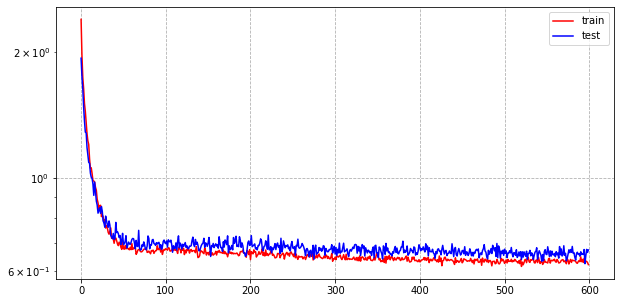

Number of parameters: 3165
nRMSE = 0.7044776292518863


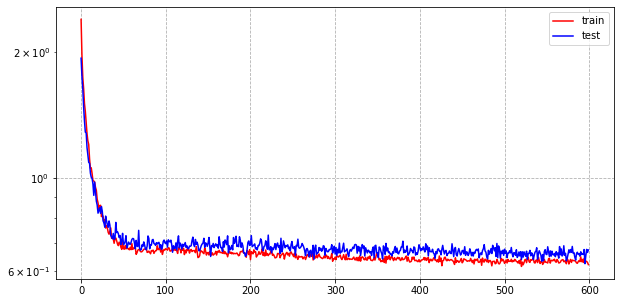

In [54]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

f_dim, N_f, N_ch = F, K, N 
#[5], 1, 8
#[3, 2], 1, 4
lr = 0.005
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_d(N_ch, N_f, f_dim).to(device)
loss_fn = my_loss_Q(1,1)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(600):
    out, y_pred, code = autoencoder(X_train.double())
    optimizer.zero_grad()
    loss = loss_fn(X_train.double(), Y_train.double(), out.double(), y_pred.double(), code.double())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_train.append(loss.item())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double(), code.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(X_train.size(0),-1)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(X_test.size(0),-1)
                    
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:', sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

In [55]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
X_train_lower.shape

(250, 6, 4, 1)

In [56]:
for rank in range(1,3,1):
    for rank1 in range(1,5,1):   
        for rank2 in range(1,2,1):
            est = TuckerRegressor(weight_ranks=[rank,rank1,rank2], verbose=0);
            Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
            for i in range(3):
                est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
                Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
            rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
            print(rank, rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 1 nRMSE by Tucker regression =  0.6869312027410097
1 2 1 nRMSE by Tucker regression =  0.669683637225616
1 3 1 nRMSE by Tucker regression =  0.6918792207677652
1 4 1 nRMSE by Tucker regression =  0.6923504403794881
2 1 1 nRMSE by Tucker regression =  0.6837339333326446
2 2 1 nRMSE by Tucker regression =  0.6642834417684815
2 3 1 nRMSE by Tucker regression =  0.6665594941150584
2 4 1 nRMSE by Tucker regression =  0.6682183469302151


## All results

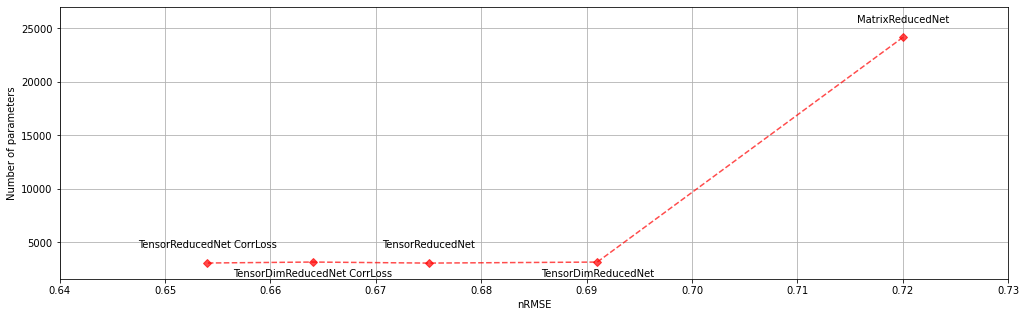

In [3]:
labels = ['MatrixReducedNet', 'TensorDimReducedNet', 'TensorReducedNet', 'TensorDimReducedNet CorrLoss', 'TensorReducedNet CorrLoss']
colors = ['r', 'b', 'black', 'y', 'purple'] 
x = [0.72, 0.691, 0.675, 0.664, 0.654]
y = [24163,3163,3069,3165,3076]
fig = plt.figure(figsize=(17,5))
plt.plot(x, y, '-gD', linestyle="--", color='red', alpha=0.7)
for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
    plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=(0,(-1)**i*15),ha="center")
plt.xlim(0.64,0.73)
plt.ylim(1600,27000)
plt.xlabel('nRMSE')
plt.ylabel('Number of parameters')
plt.grid(True)
plt.show()